In [12]:
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Input, Dense,SpatialDropout1D
from keras.layers import LSTM, Embedding
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [5]:
#df=pd.read_csv('https://raw.githubusercontent.com/kushalchauhan98/bcn-cnn-text-classification/master/hm_train.csv')
#df.to_csv('hm_train.csv')
df=pd.read_csv('hm_train.csv')

In [6]:
filter=df['cleaned_hm'].str.len()<=100
df=df[filter]

In [52]:
#rint(df)
y=df['predicted_category']

y = pd.get_dummies(df['predicted_category']).values
print('Shape of label tensor:', y.shape)

LABELS=df['predicted_category'].unique()

print(y)
print(LABELS)

# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['cleaned_hm'].values)
word_index = tokenizer.word_index

X = tokenizer.texts_to_sequences(df['cleaned_hm'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

X_train, X_test, Y_train, Y_test = train_test_split(X,y, test_size = 0.10, random_state = 42)



Shape of label tensor: (43354, 7)
[[0 1 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 ...
 [0 0 1 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]
['affection' 'exercise' 'leisure' 'achievement' 'enjoy_the_moment'
 'bonding' 'nature']
Shape of data tensor: (43354, 250)


In [38]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(len(LABELS), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [18]:
epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


Train on 35116 samples, validate on 3902 samples
Epoch 1/5
35116/35116 [==============================] - 245s 7ms/step - loss: 0.7582 - accuracy: 0.7307 - val_loss: 0.3683 - val_accuracy: 0.8795
Epoch 2/5
35116/35116 [==============================] - 267s 8ms/step - loss: 0.2626 - accuracy: 0.9103 - val_loss: 0.2448 - val_accuracy: 0.9157
Epoch 3/5
35116/35116 [==============================] - 283s 8ms/step - loss: 0.1546 - accuracy: 0.9475 - val_loss: 0.2215 - val_accuracy: 0.9190
Epoch 4/5
35116/35116 [==============================] - 272s 8ms/step - loss: 0.1033 - accuracy: 0.9638 - val_loss: 0.2287 - val_accuracy: 0.9231
Epoch 5/5
35116/35116 [==============================] - 261s 7ms/step - loss: 0.0798 - accuracy: 0.9723 - val_loss: 0.2364 - val_accuracy: 0.9203


In [19]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

4336/4336 [==============================] - 10s 2ms/step
Test set
  Loss: 0.273
  Accuracy: 0.914


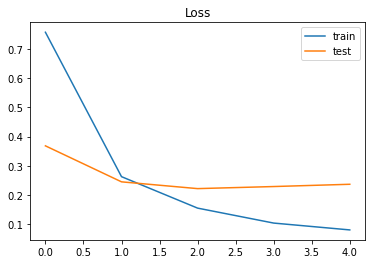

In [20]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

In [ ]:
def GetCategory(pred,LABELS):
    returnVal=[]
    curr_index=0
    curr_val=0
    for item in pred:
        val=max(item)
        index=list(item).index(val)
        #print(val,LABELS[index])
        if val>curr_val:
            curr_index=index
            curr_val=val
            
    return LABELS[curr_index]
    #returnVal.append(LABELS[np.argmax(np.array(item))])
    #return returnVal
        
for key,item in df.iterrows():
    data=[]
    data.append(item['cleaned_hm'])
    seq = tokenizer.texts_to_sequences(data)
    padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
    pred = model.predict(padded)
    print(pred)
    category=GetCategory(pred,LABELS)
    print(data, "[predicted category]", category, "[actual category]",item['predicted_category'])
    #break
    #print(pred, LABELS[np.argmax(pred)])

[[0.14630692 0.14260684 0.14227432 0.14183347 0.14210309 0.14046647
  0.14440896]]
['I went on a successful date with someone I felt sympathy and connection with.'] [predicted category] affection [actual category] affection
[[0.13995475 0.14349107 0.14165474 0.14434688 0.1423678  0.14251453
  0.14567025]]
['I was happy when my son got 90% marks in his examination '] [predicted category] nature [actual category] affection
[[0.14179811 0.14349365 0.14317858 0.14424472 0.1416171  0.14219105
  0.1434768 ]]
['I went to the gym this morning and did yoga.'] [predicted category] achievement [actual category] exercise
[[0.1430749  0.14465012 0.14322595 0.14321753 0.14120246 0.14174801
  0.14288105]]
['I went with grandchildren to butterfly display at Crohn Conservatory\r\r\n'] [predicted category] exercise [actual category] affection
[[0.14195035 0.14659217 0.14225708 0.14472568 0.14210296 0.13956693
  0.1428048 ]]
['I meditated last night.'] [predicted category] exercise [actual category] leis

[[0.14385812 0.14476138 0.14232647 0.14409435 0.1411862  0.14184426
  0.14192922]]
['I made a bunch of extra sales in my side business last night.'] [predicted category] exercise [actual category] achievement
[[0.14279209 0.14250061 0.14119095 0.14378595 0.14130245 0.14328285
  0.14514515]]
['I walked to work and back with my partner.'] [predicted category] nature [actual category] affection
[[0.14158738 0.1437058  0.14329885 0.14236346 0.14286403 0.1429138
  0.14326671]]
['I got a promotion today after 2 years of service at my job.'] [predicted category] exercise [actual category] achievement
[[0.14547326 0.14383999 0.14329788 0.14023118 0.14312191 0.14252499
  0.14151078]]
['I woke up early in the morning at 7 am against daily of 8:30 am'] [predicted category] affection [actual category] achievement
[[0.1410383  0.14217477 0.14529587 0.14426258 0.1433092  0.14142011
  0.14249916]]
['I slow cooked a chuck roast on my stove that came out great.'] [predicted category] leisure [actual ca

['I laughed with my English class about silliness during last period.'] [predicted category] enjoy_the_moment [actual category] affection
[[0.14236018 0.14274128 0.14244391 0.14346099 0.14391258 0.14136732
  0.14371374]]
['I completed all my flashcards for an upcoming test.'] [predicted category] enjoy_the_moment [actual category] achievement
[[0.14264318 0.1451232  0.14316869 0.14373484 0.14003895 0.14094499
  0.1443462 ]]
['My daughter did very good on a big test at school. '] [predicted category] exercise [actual category] affection
[[0.14339842 0.14174272 0.14146231 0.14297377 0.1424286  0.14314795
  0.14484622]]
['I am able to sleep longer than usual'] [predicted category] nature [actual category] achievement
[[0.14174691 0.14315337 0.14100553 0.14579487 0.14167562 0.14174002
  0.14488368]]
['Yesterday solved a big issue related to family'] [predicted category] achievement [actual category] achievement
[[0.14349985 0.14301121 0.14094692 0.14361121 0.14070715 0.14315347
  0.1450702

[[0.14116398 0.14436328 0.14410308 0.14383534 0.14457676 0.14050552
  0.14145206]]
[' had a great lunch with daughter and grandchildren and enjoyed out time together'] [predicted category] enjoy_the_moment [actual category] affection
[[0.14227043 0.14581026 0.14239292 0.14160252 0.14411727 0.1419739
  0.14183268]]
['I met with my old time friends.'] [predicted category] exercise [actual category] bonding
[[0.14414199 0.14125253 0.14420529 0.14104989 0.14289252 0.14180742
  0.14465034]]
['When I weighed myself this morning, I found out I was down more weight than I thought.'] [predicted category] nature [actual category] achievement
[[0.14144075 0.14491229 0.14316492 0.1438912  0.14228818 0.14093108
  0.14337166]]
['I met my childhood friend after 10 years'] [predicted category] exercise [actual category] bonding
[[0.14075953 0.14129362 0.14259417 0.14249758 0.14383516 0.14410591
  0.144914  ]]
['GO TO HOTEL PARTY OF MY MOMS BIRTHDAY'] [predicted category] nature [actual category] enjoy

['I received a call from a new client who was ready to pay me more than usual for a simple design  '] [predicted category] bonding [actual category] achievement
[[0.14168008 0.14196256 0.14408047 0.14294876 0.14272086 0.14204027
  0.14456697]]
['I doubled my daily goal for mturk rewards in a very short amount of time.'] [predicted category] nature [actual category] achievement
[[0.14442566 0.14528689 0.14269383 0.14192043 0.13927425 0.14254606
  0.1438529 ]]
['I smoked a bowl of marijuana. '] [predicted category] exercise [actual category] leisure
[[0.14570662 0.14421572 0.14242503 0.13924316 0.14369321 0.14217325
  0.14254308]]
['I was able to eat out for dinner with one of her best friends. '] [predicted category] affection [actual category] bonding
[[0.14260696 0.14122105 0.14097185 0.14323965 0.14183317 0.1442761
  0.14585125]]
['yesterday my son want to ride my bike, when he move it he got happy....me too'] [predicted category] nature [actual category] affection
[[0.1432358  0.143

[[0.1410151  0.14212367 0.14151743 0.14543185 0.14170025 0.14291698
  0.14529474]]
['My husband bought my favourite sweet that really made me very happy'] [predicted category] achievement [actual category] affection
[[0.14232865 0.14413635 0.14243996 0.14433074 0.14094964 0.14196971
  0.14384495]]
['I finally got my drivers license.'] [predicted category] achievement [actual category] achievement
[[0.14366737 0.14369678 0.14223726 0.14108495 0.14161934 0.14298326
  0.14471105]]
["We had a really good rehearsal for Friday night's play."] [predicted category] nature [actual category] enjoy_the_moment
[[0.14278875 0.14215505 0.1422865  0.14281096 0.14197071 0.14384548
  0.14414252]]
['I made a tasty chocolate pudding, and every one enjoyed it. '] [predicted category] nature [actual category] enjoy_the_moment
[[0.14096995 0.14340231 0.14269264 0.14322214 0.14200088 0.1434958
  0.14421631]]
['My husband made me my favorite food for dinner. '] [predicted category] nature [actual category] af